In [1]:
import os
import gc
import numpy as np
import pandas as pd
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "scripts"))
from pred_age_DL import (
    Config, MyData, SFCN, 
    build_model, train_or_eval
)

In [5]:
gc.collect()
torch.cuda.empty_cache()

In [6]:
config = Config(None)    
np.random.seed(config.np_seed)
torch.manual_seed(config.torch_seed)

### Inspect functions

In [ ]:
def calc_bin_centers(age_range, num_bins):
    min_age, max_age = age_range
    bin_step = (max_age - min_age) / num_bins
    age_bins = np.arange(min_age, max_age + bin_step, bin_step)
    bin_centers = (age_bins[:-1] + age_bins[1:]) / 2
    return age_bins, bin_centers

In [ ]:
def label_smoothing(x, bins, sigma):
    num_bins = len(bins) - 1
    if np.isscalar(x):
        v = np.zeros(num_bins)
        for i in range(num_bins):
            cdfs = norm.cdf([bins[i], bins[i + 1]], loc=x, scale=sigma)
            v[i] = cdfs[1] - cdfs[0]
    else:
        v = np.zeros((len(x), num_bins))
        for j, xj in enumerate(x):
            for i in range(num_bins):
                cdfs = norm.cdf([bins[i], bins[i + 1]], loc=xj, scale=sigma)
                v[j, i] = cdfs[1] - cdfs[0]
    return v

In [ ]:
age_bins, bin_centers = calc_bin_centers(config.age_range, config.num_bins)
soft_age = label_smoothing(20, age_bins, 1)
plt.figure(figsize=(3, 2))
plt.plot(soft_age)
plt.show()

### Check main

In [ ]:
# age_bins, bin_centers = calc_bin_centers(config.age_range, config.num_bins)

In [ ]:
dataset = MyData(config)
data_idxs, data_grps = np.array([ [idx, grp] for idx, (_, _, _, grp, _) in enumerate(dataset.samples) ]).T
config.bin_centers = dataset.bin_centers

In [ ]:
sss = StratifiedShuffleSplit(
    n_splits=1, test_size=config.test_ratio, random_state=config.np_seed
)
trainval_idx, test_idx = next(sss.split(data_idxs, data_grps))
loader_test = DataLoader(
    Subset(dataset, test_idx), 
    batch_size=config.batch_size, 
    shuffle=False, 
    num_workers=config.num_workers, 
    pin_memory=(config.device.type == "cuda")
)

In [ ]:
skf = StratifiedKFold(
    n_splits=config.k_folds, shuffle=True, random_state=config.np_seed
)
trainval_history = []

for fold_n, (tr_rel, va_rel) in enumerate(skf.split(trainval_idx, data_grps[trainval_idx])):
    loader_train = DataLoader(
        Subset(dataset, trainval_idx[tr_rel]), 
        batch_size=config.batch_size, 
        shuffle=True, 
        num_workers=config.num_workers, 
        pin_memory=(config.device.type == "cuda")
    )
    loader_val = DataLoader(
        Subset(dataset, trainval_idx[va_rel]), 
        batch_size=config.batch_size, 
        shuffle=False, 
        num_workers=config.num_workers, 
        pin_memory=(config.device.type == "cuda")
    )

    model = build_model(config)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    criterion = nn.KLDivLoss(reduction="batchmean").to(config.device)
    scaler = GradScaler()

    best_val = np.inf
    best_state = None
    bad_epochs = 0

    for epoch_n in range(config.num_epochs):
        avg_loss_tr = 0.0
        y_true_tr, y_pred_tr = [], []
        bin_centers = config.bin_centers.to(config.device)
        
        model.train()
        for imgs, targ_num, targ_dist in loader_train: # iterate over batches
            imgs = imgs.to(config.device)
            targ_dist = targ_dist.to(config.device)
            optimizer.zero_grad(set_to_none=True) # clear gradients
            with autocast(device_type=config.device.type, dtype=torch.float16):
                log_probs = model(imgs) # forward propagation
                loss = criterion(log_probs, targ_dist) 
            scaler.scale(loss).backward() # compute gradients
            scaler.step(optimizer) # update weights
            scaler.update()
            avg_loss_tr += loss.item() * imgs.size(0) # weighted by batch size
            probs = torch.exp(log_probs)
            pred_num = torch.matmul(probs.squeeze(), bin_centers)
            y_pred_tr.append(pred_num.detach().cpu().numpy().reshape(-1))
            y_true_tr.append(targ_num.numpy().reshape(-1))
            break
        
        avg_loss_tr /= len(loader_train.dataset) # weighted average
        y_true_tr = np.concatenate(y_true_tr)
        y_pred_tr = np.concatenate(y_pred_tr)
        
        break
    break

In [ ]:
sidx = 0
y_pred_dist = probs.detach().cpu().numpy()[sidx].reshape(-1)
y_true_dist = np.exp(targ_dist.detach().cpu().numpy()[sidx].reshape(-1))
bc = config.bin_centers.numpy()

In [ ]:
fig = plt.figure(figsize=(3, 2))
plt.bar(bc, y_pred_dist, alpha=.6)
plt.bar(bc, y_true_dist, color="orange", alpha=.6)
plt.show()

### Check nii image

In [28]:
import nibabel as nib
from nilearn import image, plotting

In [25]:
subj_list_path = os.path.join("..", "data", "meta", "subj_list.txt")
subj_list = pd.read_csv(subj_list_path, header=None)[0].values

In [26]:
sid = subj_list[0]

In [ ]:
subj_infos_path = os.path.join("..", "data", "meta", "subj_infos.csv")
subj_infos = pd.read_csv(subj_infos_path)
subj_infos.set_index("SID", inplace=True)

In [ ]:
subj_infos = subj_infos.loc[subj_list, :]
subj_infos["Age"].agg(["min", "max"])
subj_infos.query("Age == 19")
# subj_infos["Sex"].unique()
# subj_infos.query("Sex not in ['M', 'F']")

In [ ]:
# anat_dir = os.path.join("..", "data", "fmriprep", sid, "ses-01", "anat")
# anat_path = os.path.join(anat_dir, f"{sid}_ses-01_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz")
# mask_path = os.path.join(anat_dir, f"{sid}_ses-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")
# mask_img, anat_img = nib.load(mask_path), nib.load(anat_path)

In [ ]:
# plotting.plot_roi(mask_img, anat_img, alpha=.3, cmap="cool", colorbar=False)

In [27]:
img_path = os.path.join(
    "..", "data", "processed", 
    ["preproc_MNI_wholebrain_scaled", 
     "preproc_MNI_wholebrain_cropped"][-1], 
    f"{sid}_ses-01_space-MNI152NLin2009cAsym_desc-brain_T1w.nii.gz"
)

In [ ]:
# plotting.plot_img(img_path, cut_coords=(0, -21, 9))

In [46]:
img = nib.load(img_path)
print([f"{x:.1f}" for x in img.header.get_zooms()])
print(img.shape)
print(nib.orientations.aff2axcodes(img.affine))

['1.0', '1.0', '1.0']
(160, 192, 160)
('R', 'A', 'S')


In [47]:
img_data = img.get_fdata()
print(img_data.dtype)

float64


In [ ]:
data = np.random.rand(160, 192, 160)
data /= data.mean()

In [ ]:
data.shape

In [ ]:
# img_tensor = torch.tensor(img_data).unsqueeze(0)
# print(img_tensor.shape)

In [ ]:
# mask_path = os.path.join("..", "data", "processed", "union_mask.nii.gz")
# mask_img = nib.load(mask_path)
# mask_data = mask_img.get_fdata()
# print(mask_data.shape)

In [ ]:
# plotting.plot_img(mask_img)

In [ ]:
# def calc_crop_indices(input_shape, output_shape):
#     x = ((input_shape[0] - output_shape[0]) // 2, (input_shape[0] + output_shape[0]) // 2)
#     y = ((input_shape[1] - output_shape[1]) // 2, (input_shape[1] + output_shape[1]) // 2)
#     z = ((input_shape[2] - output_shape[2]) // 2, (input_shape[2] + output_shape[2]) // 2)
#     return x, y, z

In [ ]:
# input_shape = (193, 229, 193)
# output_shape = (160, 192, 160)
# x, y, z = calc_crop_indices(input_shape, output_shape)
# cropped_img = img.slicer[x[0]:x[1], y[0]:y[1], z[0]:z[1]]
# print(cropped_img.shape)

In [ ]:
# def compute_bbox(data, threshold=0, pad=1):
#     coords = np.array(np.where(data > threshold))
#     start = coords.min(axis=1)
#     end = coords.max(axis=1) + 1
#     if pad > 0:
#         start = np.maximum(start - pad, 0)
#         end = np.minimum(end + pad, data.shape)
#     return np.array([start, end]).T

In [ ]:
# [x, y, z] = compute_bbox(mask_data)
# cropped_img = img.slicer[x[0]:x[1], y[0]:y[1], z[0]:z[1]]
# print(cropped_img.shape)

In [ ]:
# plotting.plot_img(cropped_img)

### Check model

In [61]:
from torchinfo import summary

In [7]:
model = SFCN(config)
checkpoint = torch.load(config.pretrained_model_path, map_location=config.device)
state_dict = { k: v for k, v in zip(model.state_dict().keys(), checkpoint.values()) }
model.load_state_dict(state_dict)

<All keys matched successfully>

In [54]:
x = (
    torch.tensor(np.ones((1, 1, 160, 192, 160)), dtype=torch.float32), 
    # torch.tensor(img_data, dtype=torch.float32).unsqueeze(dim=0).unsqueeze(dim=0), 
    # torch.tensor(img_data.transpose(2, 1, 0), dtype=torch.float32).unsqueeze(dim=0).unsqueeze(dim=0)
)[0]

In [59]:
model.eval()
with torch.no_grad():
    x_f = model.feature_extractor.block_0(x)
    # x_f = model.feature_extractor.block_1(x_f)
    # x_f = model.feature_extractor.block_2(x_f)
    # x_f = model.feature_extractor.block_3(x_f)
    # x_f = model.feature_extractor.block_4(x_f)
    # x_f = model.feature_extractor.block_5(x_f)
x_f = x_f.detach().cpu()[0].numpy() 

In [ ]:
def 

In [18]:
def pick_top_channels_by_var(x_f, top_k=12):
    c_num = x_f.shape[0] # number of channels
    x_vars = x_f.reshape(c_num, -1).var(axis=1) 
    return np.argsort(x_vars)[::-1][:top_k]

In [57]:
def show_feature_maps_by_channel(x_f, c_idxs, plane="axial", slice_idx=None, ncols=4):
    assert len(x_f.shape) == 4
    _, *x_dims = x_f.shape # (X, Y, Z)
    plane_idx = ["axial", "coronal", "sagittal"].index(plane)
    slice_idx = (x_dims[plane_idx] // 2) if slice_idx is None else slice_idx # middle slice
    nrows = int(np.ceil(len(c_idxs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
    axes = np.array(axes).reshape(-1)
    for i, c in enumerate(c_idxs):
        axes[i].imshow((
            x_f[c, :, :, slice_idx], # X-Y
            x_f[c, :, slice_idx, :], # X-Z
            x_f[c, slice_idx, :, :]  # Y-Z
        )[plane_idx], cmap="gray")
        axes[i].set_title(f"ch-{c}")
        axes[i].axis("off")
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.suptitle(f"{plane} plane, {slice_idx}-th slice")
    plt.tight_layout()
    plt.show()

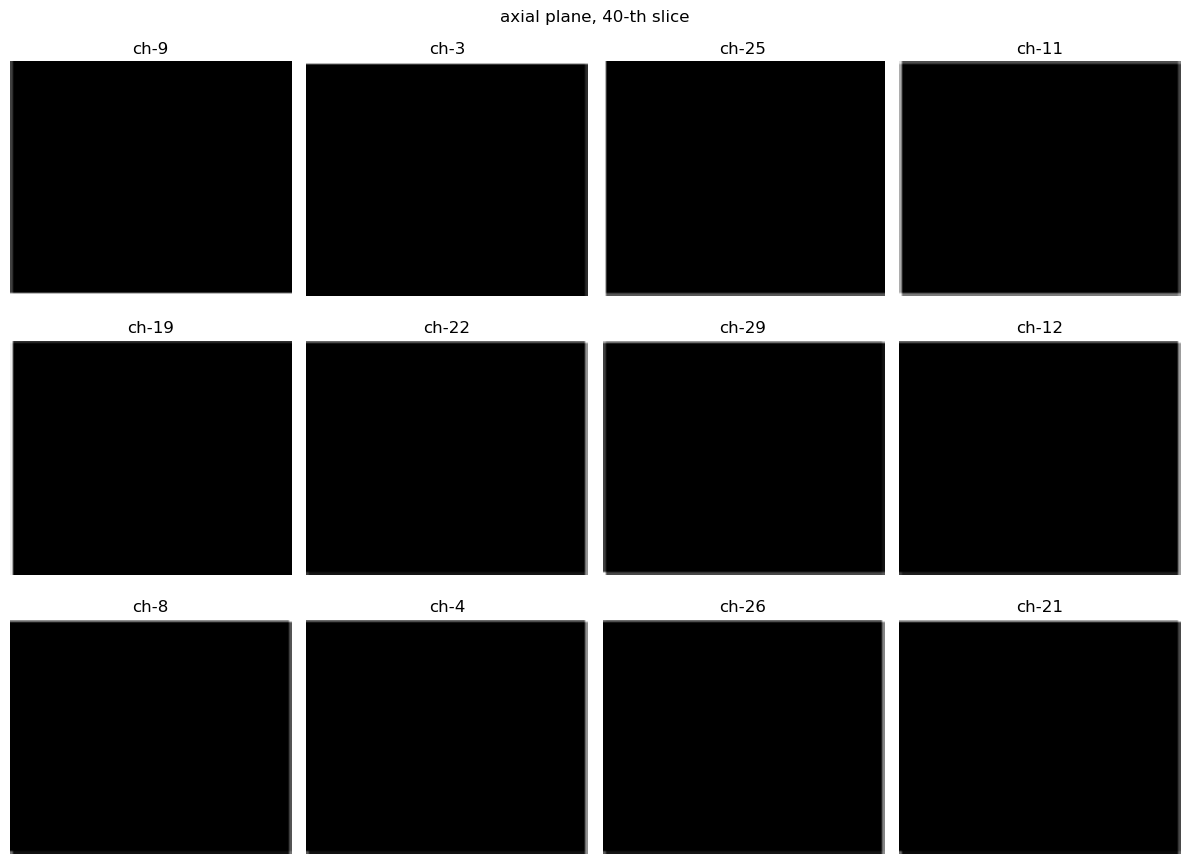

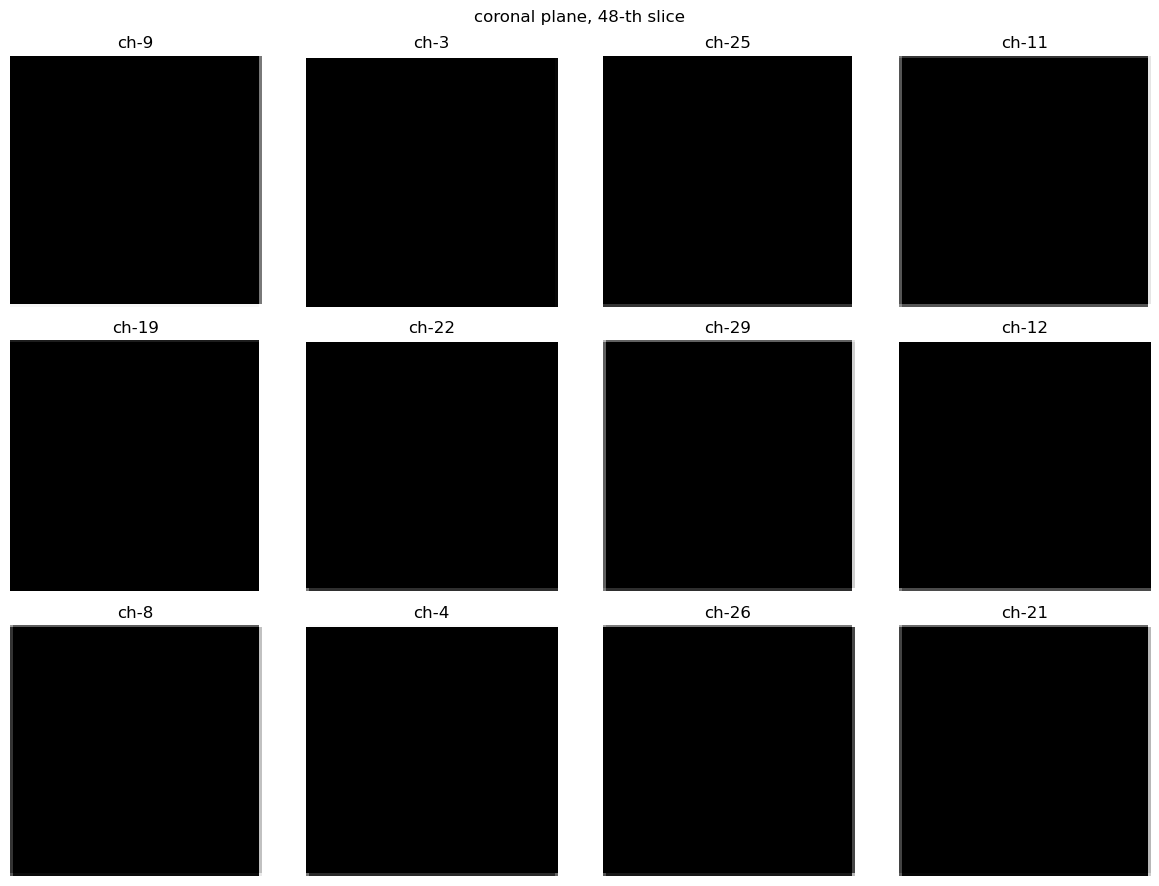

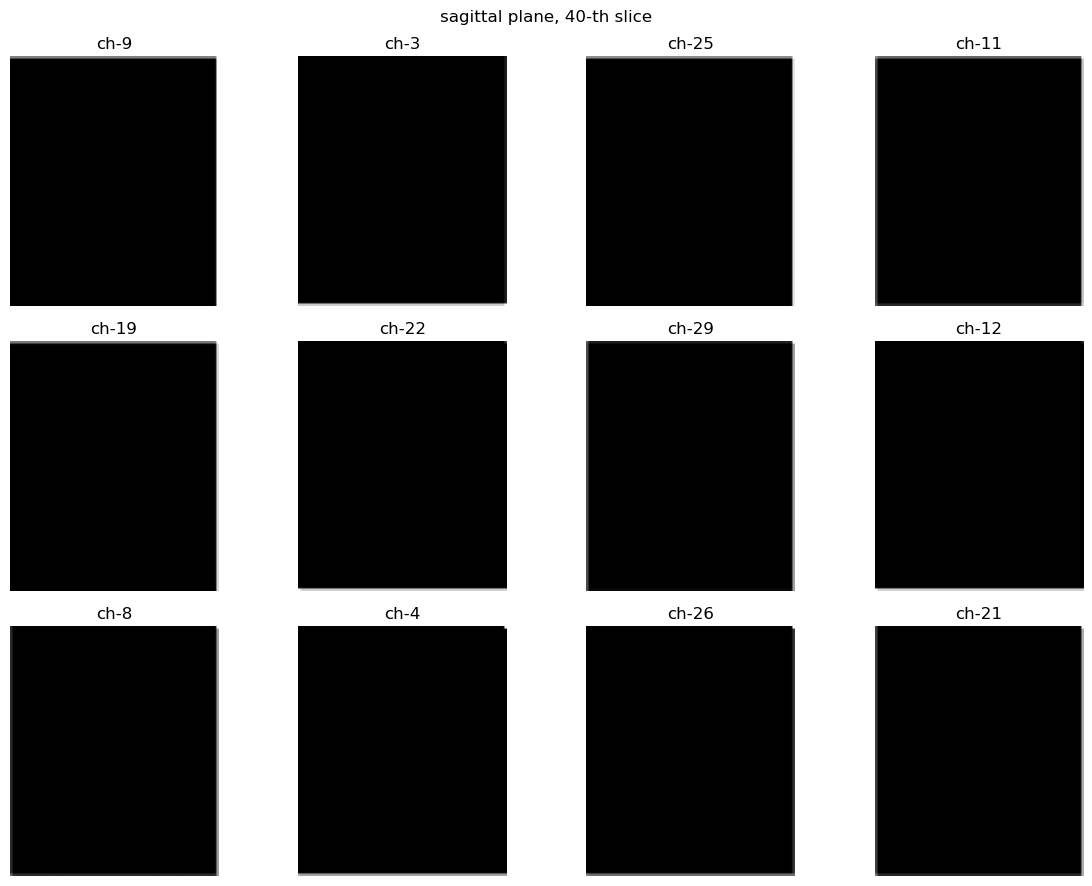

In [60]:
top_ch = pick_top_channels_by_var(x_f, top_k=12)
for plane in ["axial", "coronal", "sagittal"]:
    show_feature_maps_by_channel(x_f, top_ch, plane=plane)

In [ ]:
print(model)

In [65]:
896 / 32 

28.0

In [62]:
summary(model=model, input_size=(1, 1, 160, 192, 160))

Layer (type:depth-idx)                   Output Shape              Param #
SFCN                                     [1, 40, 1, 1, 1]          --
├─Sequential: 1-1                        [1, 64, 5, 6, 5]          --
│    └─Sequential: 2-1                   [1, 32, 80, 96, 80]       --
│    │    └─Conv3d: 3-1                  [1, 32, 160, 192, 160]    896
│    │    └─BatchNorm3d: 3-2             [1, 32, 160, 192, 160]    64
│    │    └─MaxPool3d: 3-3               [1, 32, 80, 96, 80]       --
│    │    └─ReLU: 3-4                    [1, 32, 80, 96, 80]       --
│    └─Sequential: 2-2                   [1, 64, 40, 48, 40]       --
│    │    └─Conv3d: 3-5                  [1, 64, 80, 96, 80]       55,360
│    │    └─BatchNorm3d: 3-6             [1, 64, 80, 96, 80]       128
│    │    └─MaxPool3d: 3-7               [1, 64, 40, 48, 40]       --
│    │    └─ReLU: 3-8                    [1, 64, 40, 48, 40]       --
│    └─Sequential: 2-3                   [1, 128, 20, 24, 20]      --
│    │   

### Footnotes

#### Simple Fully Convolutional Network (SFCN)
- Paper: https://doi.org/10.1016/j.media.2020.101871
- Repo: https://github.com/ha-ha-ha-han/UKBiobank_deep_pretrain/
- https://medium.com/@daminininad/intro-to-ai-with-neuroimaging-data-a-end-to-end-tutorial-using-pytorch-f941c6ef547a

#### Useful:
- https://glassboxmedicine.com/2021/02/06/designing-custom-2d-and-3d-cnns-in-pytorch-tutorial-with-code/
- https://github.com/westman-neuroimaging-group/brainage-prediction-mri/tree/main
- https://tangh.github.io/articles/build-model-and-dataset-in-pytorch/
- https://chih-sheng-huang821.medium.com/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-convolutional-neural-network-cnn-cnn%E9%81%8B%E7%AE%97%E6%B5%81%E7%A8%8B-ecaec240a631

#### PyTorch APIs
- https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
- https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
- https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv3d.html
- https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm3d.html
- https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool3d.html
- https://docs.pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool3d.html
- https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html
- https://docs.pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html

#### Nibabel
- https://nipy.org/nibabel/manual.html#manual
- https://nipy.org/nibabel/nibabel_images.html